In [4]:
import torch
import numpy as np
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms

import mask_generation
import ImageDataset
import ssim

import matplotlib.pyplot as plt

In [7]:
torch.zeros(5) == 0

tensor([ 1,  1,  1,  1,  1], dtype=torch.uint8)

In [8]:
class _NormalizedConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1):
        super(_NormalizedConv2d, self).__init__()
        self.in_channels = in_channels
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride,
                              padding=padding, dilation=dilation, bias=False)
        self.conv.weight.data = torch.randn_like(self.conv.weight.data) - 0.5
        self.norm_conv = torch.nn.utils.weight_norm(self.conv)
        self.bias = nn.Parameter(torch.zeros((out_channels, 1, 1)), requires_grad=True)
        
    def forward(self, x):
        certainty = (x != 0).float()
        conv_out = self.conv(x)
        cert_out = self.conv(certainty)
        normed = torch.where(cert_out!=0, conv_out/cert_out, torch.zeros_like(conv_out))
        
        return normed + self.bias

In [9]:
norm_conv = _NormalizedConv2d(3, 4, 3, padding = 1)

In [10]:
val_dataset = ImageDataset.ImageDataset(["../data/mscoco_test2017/"], im_size=8)
mask_gen = mask_generation.MaskGenerator(im_size = 8)

In [11]:
sample = val_dataset.__getitem__(11)
transforms.ToPILImage()(sample)

In [12]:
mask, x, y = mask_gen.generate_mask()
mask[mask>0] = 1

In [13]:
mask

tensor([[[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 1.,  1.,  1.,  1.,  0.,  0.,  0.,  0.],
         [ 1.,  1.,  1.,  1.,  0.,  0.,  0.,  0.],
         [ 1.,  1.,  1.,  1.,  0.,  0.,  0.,  0.],
         [ 1.,  1.,  1.,  1.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]]])

In [14]:
masked = sample * (1-mask)

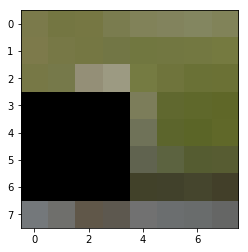

In [15]:
plt.imshow(np.array(transforms.ToPILImage()(masked)), cmap='gray');

In [16]:
f = norm_conv(Variable(masked).unsqueeze(0))

In [17]:
f[0][0][0][0].data.numpy()

array(0.37866986, dtype=float32)

In [18]:
f

tensor([[[[ 0.3787,  0.3973,  0.3868,  0.3879,  0.3962,  0.4073,  0.4111,
            0.4393],
          [ 0.3736,  0.3990,  0.4324,  0.4479,  0.4262,  0.3977,  0.3858,
            0.4009],
          [ 0.3884,  0.3550,  0.3806,  0.4237,  0.3931,  0.3593,  0.3347,
            0.3566],
          [ 0.3756,  0.4599,  0.5614,  0.4270,  0.3567,  0.3431,  0.3056,
            0.3317],
          [ 0.0000,  0.0000,  0.0000,  0.3473,  0.3466,  0.3168,  0.2857,
            0.3097],
          [ 0.0000,  0.0000,  0.0000,  0.2960,  0.2845,  0.2649,  0.2575,
            0.2748],
          [ 0.4599,  0.4218,  0.3754,  0.3575,  0.3570,  0.3298,  0.3207,
            0.3266],
          [ 0.4490,  0.4530,  0.3990,  0.2653,  0.2766,  0.3163,  0.3104,
            0.3463]],

         [[ 0.4396,  0.4104,  0.4073,  0.4109,  0.4203,  0.4245,  0.4292,
            0.4319],
          [ 0.4319,  0.4447,  0.4794,  0.4701,  0.4323,  0.4224,  0.4162,
            0.4220],
          [ 0.4483,  0.4460,  0.4849,  0.4759,  

In [19]:
out = f.mean()

In [20]:
out.backward()